In [ ]:
import os
import pandas as pd

# Path to the folder inside "logs"
folder_path = os.path.join("logs_archive", "run_20250505_030057")


# Create a list to store file info
file_info = []

# Loop through each file and get row counts
for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path) as f:
                row_count = sum(1 for _ in f) - 1  # subtract 1 for header
            file_info.append({"filename": filename, "row_count": row_count})
        except Exception as e:
            file_info.append({"filename": filename, "row_count": f"Error: {e}"})

# Convert to DataFrame
row_counts_df = pd.DataFrame(file_info)

# Display the DataFrame
row_counts_df



,filename,row_count
0,avg-sigma.csv,1107
1,fillin-pass.csv,4835
2,pcg-resid.csv,4835
3,line-search.csv,4835
4,max-search-dir.csv,4835
5,dyn-consumed.csv,4835
6,toi-recale.csv,4835
7,initialize.csv,1
8,dt.csv,1107
9,num-contact.csv,4835


In [ ]:

# around row 641 for csvs with 1107 rows is when dt might have changed 
# Load the CSV
df = pd.read_csv("logs_archive/run_20250505_030057/newton-steps.csv")
df['time'] = df['time_or_frame'].copy()
df['newton_steps'] = df['value'].copy()

# Calculate the difference between consecutive vid_time values
df['vid_time_diff'] = df['time'].diff()

# Find the first index where the increment is (roughly) 0.02
threshold = 0.015  # in case it's slightly off from 0.02 due to float rounding
switch_row = df[df['vid_time_diff'] > threshold].index[0]

# Show the row and maybe a few before/after for context
df.iloc[switch_row - 2 : switch_row + 3]
df


,time_or_frame,value,time,newton_steps,vid_time_diff
0,0.000000,3,0.000000,3,NaN
1,0.000227,2,0.000227,2,0.000227
2,0.000507,1,0.000507,1,0.000280
3,0.000694,2,0.000694,2,0.000187
4,0.000883,3,0.000883,3,0.000189
...,...,...,...,...,...
1102,3.968071,1,3.968071,1,0.019976
1103,3.975487,1,3.975487,1,0.007416
1104,3.983251,1,3.983251,1,0.007764
1105,3.990983,1,3.990983,1,0.007732


In [ ]:
# this successfully maps frames to newton steps!!!!


# Load both CSVs
newton_df = pd.read_csv("logs_archive/run_20250505_030057/newton-steps.csv")
frame_df = pd.read_csv("logs_archive/run_20250505_030057/frame-to-time.csv")
newton_df['time'] = newton_df['time_or_frame'].copy()
newton_df['newton_steps'] = newton_df['value'].copy()
newton_df = newton_df[['time','newton_steps']]

frame_df['frame'] = frame_df['time_or_frame'].copy()
frame_df['time']=frame_df['value'].copy()
frame_df = frame_df[['frame','time']]
frame_df = frame_df.sort_values("time").reset_index(drop=True)


# Merge on the closest matching time using merge_asof
frame_df_sorted = frame_df.sort_values("time")
newton_df_sorted = newton_df.sort_values("time")

# Map time to closest frame time
merged_df = pd.merge_asof(newton_df_sorted, frame_df_sorted, on="time", direction='backward')

# Rename for clarity
merged_df = merged_df.rename(columns={"frame": "corresponding_frame"})

# Optional: see the result
merged_df.head()

pcg = pd.read_csv("logs_archive/run_20250505_030057/pcg-iter.csv")

pcg['time'] = pcg['time_or_frame'].copy()
pcg['iterations'] = pcg['value'].copy()
pcg = pcg[['time','iterations']]
# Map time to closest frame time
merged_df2 = pd.merge_asof(pcg, merged_df, on="time", direction='backward')
# Rename for clarity
merged_df2 = merged_df2.rename(columns={"frame": "corresponding_frame"})
# Optional: see the result
merged_df2.head()


,time,newton_steps,corresponding_frame
0,0.000000,3,0
1,0.000227,2,0
2,0.000507,1,0
3,0.000694,2,0
4,0.000883,3,0


In [ ]:
pcg = pd.read_csv("logs_archive/run_20250505_030057/pcg-iter.csv")

pcg['time'] = pcg['time_or_frame'].copy()
pcg['iterations'] = pcg['value'].copy()
pcg = pcg[['time','iterations']]
# Map time to closest frame time
merged_df2 = pd.merge_asof(pcg, merged_df, on="time", direction='backward')
# Rename for clarity
merged_df2 = merged_df2.rename(columns={"frame": "corresponding_frame"})
# Optional: see the result
merged_df2.head()

,time,iterations,newton_steps,corresponding_frame
0,0.000000,262,3,0
1,0.000000,325,3,0
2,0.000000,331,3,0
3,0.000000,166,3,0
4,0.000227,331,2,0


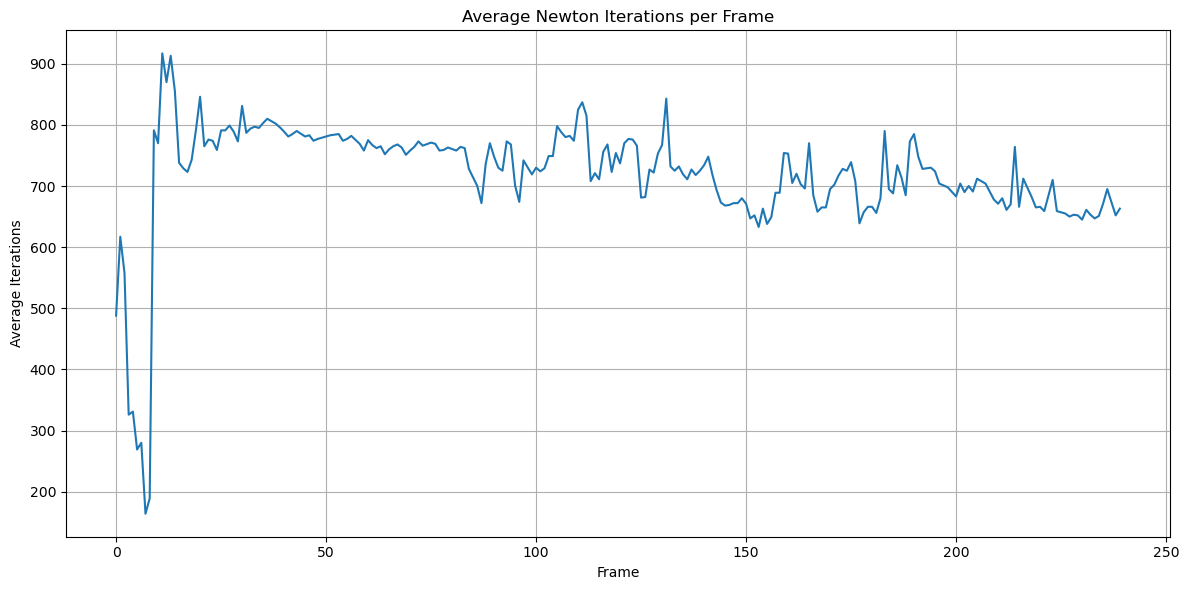

In [15]:
import matplotlib.pyplot as plt

# Group by 'corresponding_frame' and calculate average iterations
avg_iterations_per_frame = merged_df2.groupby('corresponding_frame')['iterations'].max().reset_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_iterations_per_frame['corresponding_frame'], avg_iterations_per_frame['iterations'])
plt.title('Average Newton Iterations per Frame')
plt.xlabel('Frame')
plt.ylabel('Average Iterations')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
import os
import pandas as pd

def merge_logs(folder_path):
    """
    Merges newton-steps.csv, frame-to-time.csv, and pcg-iter.csv from a given log folder.
    Returns a DataFrame with time, newton_steps, iterations, and corresponding_frame.
    """
    # Load and preprocess newton-steps
    newton_df = pd.read_csv(os.path.join(folder_path, "newton-steps.csv"))
    newton_df['time'] = newton_df['time_or_frame']
    newton_df['newton_steps'] = newton_df['value']
    newton_df = newton_df[['time', 'newton_steps']].sort_values('time')

    # Load and preprocess frame-to-time
    frame_df = pd.read_csv(os.path.join(folder_path, "frame-to-time.csv"))
    frame_df['frame'] = frame_df['time_or_frame']
    frame_df['time'] = frame_df['value']
    frame_df = frame_df[['frame', 'time']].sort_values('time').reset_index(drop=True)

    # Merge newton steps to frame
    merged_df = pd.merge_asof(newton_df, frame_df, on="time", direction='backward')
    merged_df = merged_df.rename(columns={"frame": "corresponding_frame"})

    # Load and preprocess pcg-iter
    pcg_df = pd.read_csv(os.path.join(folder_path, "pcg-iter.csv"))
    pcg_df['time'] = pcg_df['time_or_frame']
    pcg_df['iterations'] = pcg_df['value']
    pcg_df = pcg_df[['time', 'iterations']].sort_values('time')

    # Merge pcg data
    final_df = pd.merge_asof(pcg_df, merged_df, on="time", direction='backward')

    return final_df


In [17]:
import glob

all_dfs = []

# Iterate over all folders inside logs_archive
for path in glob.glob("logs_archive/*"):
    if os.path.isdir(path):
        try:
            df = merge_logs(path)
            df['source_folder'] = os.path.basename(path)  # add where it came from
            all_dfs.append(df)
        except Exception as e:
            print(f"Failed to process {path}: {e}")


In [21]:
all_combined_df = pd.concat(all_dfs, ignore_index=True)
all_combined_df.to_csv("all_logs_combined.csv", index=False)


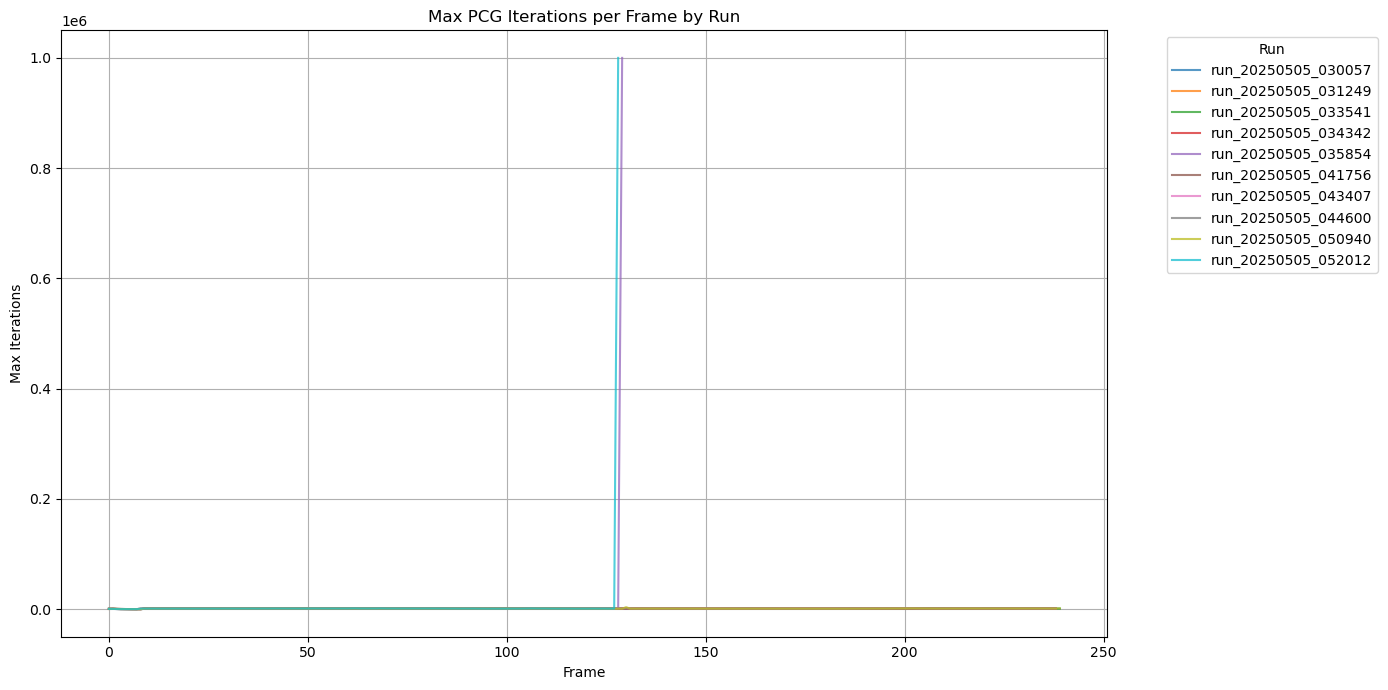

In [19]:
# Make sure the DataFrame includes a 'source_folder' column
grouped = all_combined_df.groupby(['source_folder', 'corresponding_frame'])['iterations'].max().reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot each run's max iterations per frame
for run_name in grouped['source_folder'].unique():
    run_data = grouped[grouped['source_folder'] == run_name]
    plt.plot(run_data['corresponding_frame'], run_data['iterations'], label=run_name, alpha=0.75)

plt.title("Max PCG Iterations per Frame by Run")
plt.xlabel("Frame")
plt.ylabel("Max Iterations")
plt.legend(title="Run", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



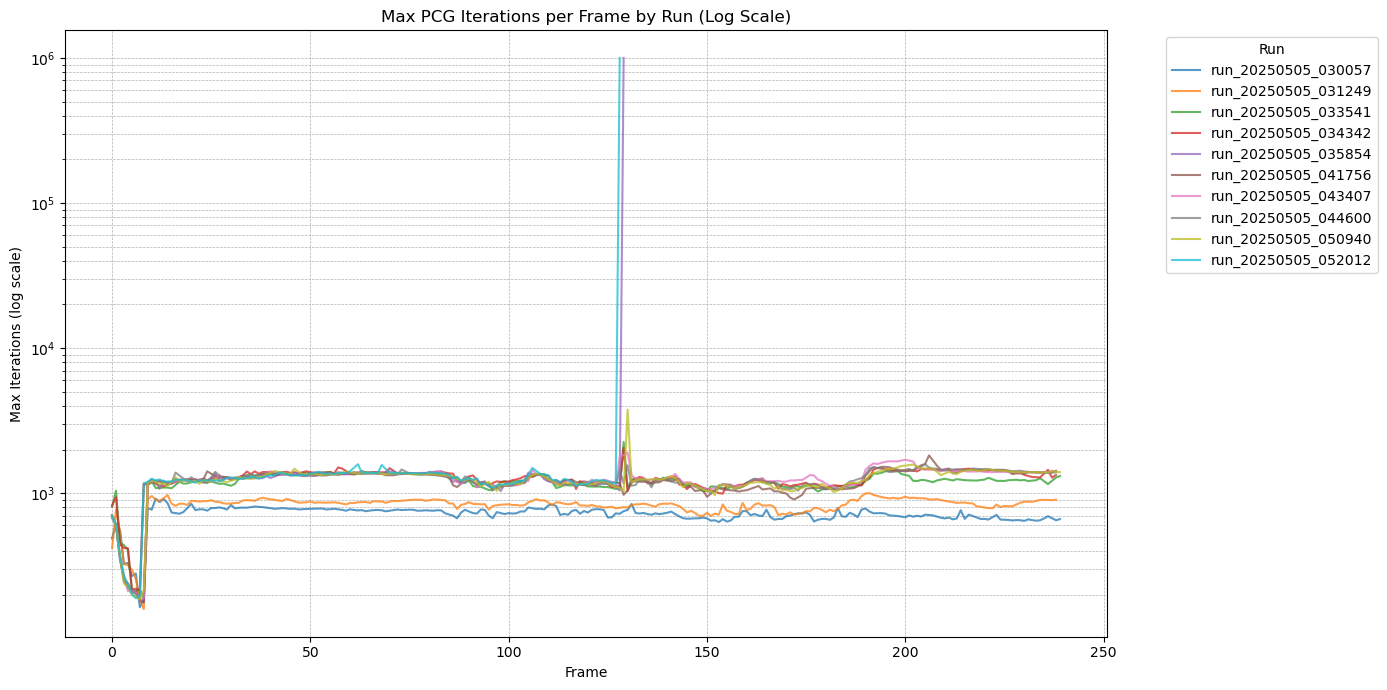

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

for run_name in grouped['source_folder'].unique():
    run_data = grouped[grouped['source_folder'] == run_name]
    plt.plot(run_data['corresponding_frame'], run_data['iterations'], label=run_name, alpha=0.75)

plt.yscale('log')  # log scale
plt.title("Max PCG Iterations per Frame by Run (Log Scale)")
plt.xlabel("Frame")
plt.ylabel("Max Iterations (log scale)")
plt.legend(title="Run", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## TODO
I think i'm at a really place right now to play round with the simulation more. I read GPU_IPC's research paper and thier netwon methods are in the 1e4 range, which is way over mine. They included a chart that features the paramters they used, like time step size, density modulus, number of vertices, etc so next I want to mimic those paramters. Hopefully I don't come into any computation power problems with the solver. 
I want to compare how many vertices are in my cloth vs theirs, and increase cg-max-iter and maybe cg-tol, if necesarry. From there, I think I need to start over again with running and collecting data to process here, but I think i've streamlined the process enough for it to not be that bad. 

I think pcg tol should be 1e-4?????????

v: interior for tetrahedral meshes (v)

t: number of tetrahedra
 
f:  number of surface triangles (f) 

Δt: time-step size in seconds

ρ: material density 
 
E: Young’s modulusin units of pascals Pa
 
υ: Poisson’s ratio 
  
ˆd: computational accuracy target in meters , which is set w.r.t. to the scene bounding box diagonal length l

ϵd: Newton Solver tolerance threshold 
 
μ: friction coefficient 
 
ϵv: velocity magnitude bound 
 
#Δt: Total number of time steps (#Δt)



Total time to build/find contact pairs (buildCP); Total time to build energy gradients and Hessians for all types (buildGH); Total linear solver time (solve); Total CCD time
(CCD); Average number of Newton iterations per time step (#i)